In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import tqdm
import utils as utils
import scienceplots
plt.style.use('science')

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

import fit_FaIRGP as fairgp
import fit_GP as plaingp
from src.structures import Scenario, ScenarioDataset

<IPython.core.display.Javascript object>

In [3]:
# Create a fiction scenario based on SSP245 where all GHG emissions suddenly go to zero
cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp245']}}
data = plaingp.make_data(cfg)
timesteps = data.scenarios[0].timesteps
emissions = data.scenarios[0].emissions
emissions[:, 0] = 0
emissions[:, 1] = 0
stopGHG = Scenario(name='stop-GHG',
                   timesteps=timesteps,
                   emissions=emissions,
                   tas=torch.nan * torch.ones_like(timesteps),
                   hist_scenario=data.scenarios.hist_scenario)

In [4]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']}}
train_data = plaingp.make_data(train_cfg)

gpmodel = plaingp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/all-ssps/PlainGP/state_dict.pt')
gpmodel.load_state_dict(state_dict)

fairgpmodel = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/all-ssps/FaIRGP/state_dict.pt')
fairgpmodel.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
test_scenarios = ScenarioDataset([stopGHG], hist_scenario=stopGHG.hist_scenario)

In [6]:
test_times = test_scenarios.full_timesteps
test_tas = test_scenarios.full_tas
test_tas_fair = fairgpmodel._compute_mean(test_scenarios)
X_test = torch.cat([test_scenarios.cum_emissions[:, 0, None],
                    test_scenarios.emissions[:, 1:]], dim=-1)
X_test = (X_test - gpmodel.mu) / gpmodel.sigma

gpmodel = gpmodel.eval()
fairgpmodel = fairgpmodel.eval()

with torch.no_grad():
    gp_test_posterior = gpmodel(X_test)
    mean = gpmodel.sigma_targets * gp_test_posterior.mean + gpmodel.mu_targets
    covar = gpmodel.sigma_targets.pow(2) * gp_test_posterior.covariance_matrix
    gp_test_posterior = gp_test_posterior.__class__(mean, gpytorch.add_jitter(covar))
    
    noisy_gp_test_posterior = gpmodel.likelihood(gpmodel(X_test))
    mean = gpmodel.sigma_targets * noisy_gp_test_posterior.mean + gpmodel.mu_targets
    covar = gpmodel.sigma_targets.pow(2) * noisy_gp_test_posterior.covariance_matrix
    noisy_gp_test_posterior = noisy_gp_test_posterior.__class__(mean, covar)
    
with torch.no_grad():
    fairgp_test_posterior = fairgpmodel(test_scenarios)
    noisy_fairgp_test_posterior = fairgpmodel.likelihood(fairgp_test_posterior)

/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:25: UserWarning: gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense
  warnings.warn("gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense")


In [7]:
hist_renamed = stopGHG.hist_scenario
hist_renamed.name = 'hist-bis'
full_test_scenarios = ScenarioDataset([hist_renamed, stopGHG], hist_scenario=stopGHG.hist_scenario)
with torch.no_grad():
    posterior_F = fairgpmodel.forcing_posterior(full_test_scenarios)
    mF = fairgpmodel._compute_forcing_mean(full_test_scenarios)
posterior_forcing_mean = posterior_F.mean
posterior_forcing_lb, posterior_forcing_ub = posterior_F.confidence_region()

In [8]:
gp_posterior_mean = noisy_gp_test_posterior.mean
gp_posterior_lb, gp_posterior_ub = gp_test_posterior.confidence_region()
gp_posterior_lb = gp_posterior_lb.detach()
gp_posterior_ub = gp_posterior_ub.detach()

noisy_gp_posterior_lb, noisy_gp_posterior_ub = noisy_gp_test_posterior.confidence_region()
noisy_gp_posterior_lb = noisy_gp_posterior_lb.detach()
noisy_gp_posterior_ub = noisy_gp_posterior_ub.detach()

In [9]:
fairgp_posterior_mean = fairgp_test_posterior.mean + test_tas_fair
fairgp_posterior_lb, fairgp_posterior_ub = fairgp_test_posterior.confidence_region()
fairgp_posterior_lb = fairgp_posterior_lb.detach() + test_tas_fair
fairgp_posterior_ub = fairgp_posterior_ub.detach() + test_tas_fair

noisy_fairgp_posterior_lb, noisy_fairgp_posterior_ub = noisy_fairgp_test_posterior.confidence_region()
noisy_fairgp_posterior_lb = noisy_fairgp_posterior_lb.detach() + test_tas_fair
noisy_fairgp_posterior_ub = noisy_fairgp_posterior_ub.detach() + test_tas_fair

In [10]:
test_tas_fair = fairgpmodel._compute_mean(full_test_scenarios)

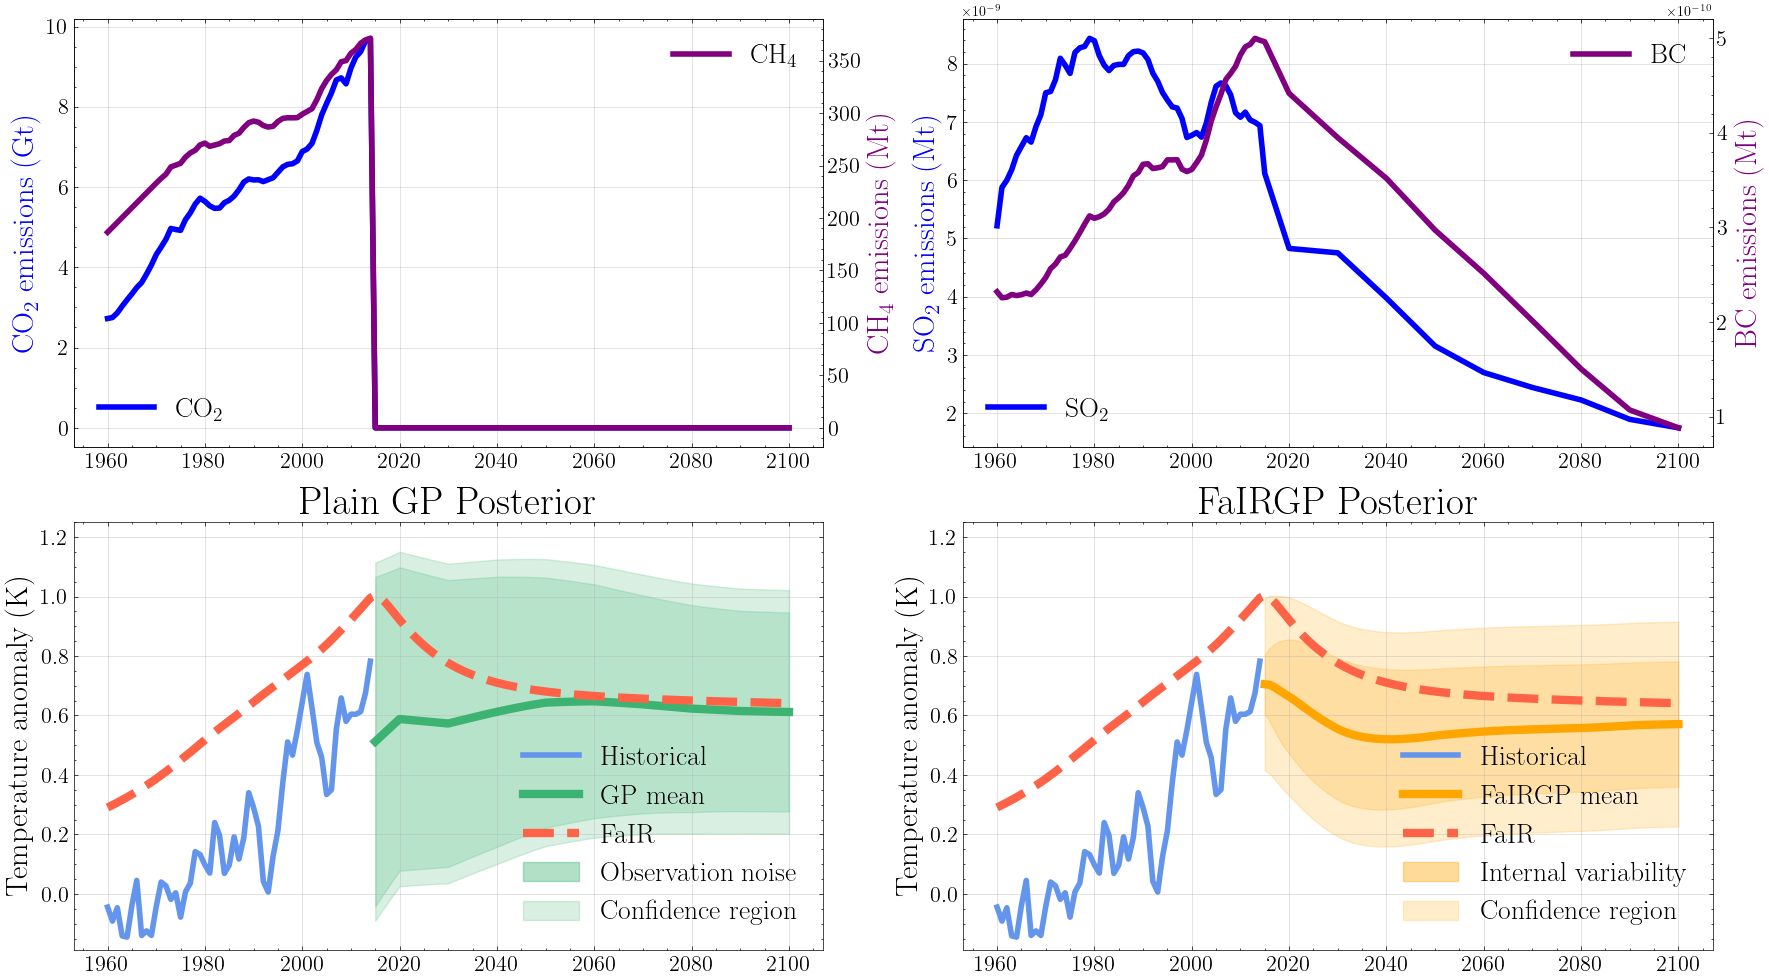

In [57]:
fig, ax = plt.subplots(2, 2, figsize=(18, 10))

ymax = max(noisy_fairgp_posterior_ub.max(), noisy_gp_posterior_ub.max()) + 0.1
ymin = min(noisy_fairgp_posterior_lb.min(), noisy_gp_posterior_lb.min()) - 0.1
tshift = 110


ax[0, 0].plot(test_times[tshift:], stopGHG.full_emissions[tshift:, 0], lw=4, color='blue', label=r'CO$_2$')
ax[0, 0].set_ylabel(r'CO$_2$ emissions (Gt)', fontsize=22)
ax[0, 0].tick_params(labelsize=16)
ax[0, 0].grid(alpha=0.5)
ax[0, 0].yaxis.label.set_color('blue')
ax[0, 0].legend(fontsize=20, loc='lower left')
ax2 = ax[0, 0].twinx()
ax2.plot(test_times[tshift:], stopGHG.full_emissions[tshift:, 1], lw=4, color='purple', label=r'CH$_4$')
ax2.set_ylabel(r'CH$_4$ emissions (Mt)', fontsize=22)
ax2.tick_params(labelsize=16)
ax2.yaxis.label.set_color('purple')
ax2.legend(fontsize=20, loc='upper right')


ax[0, 1].plot(test_times[tshift:], stopGHG.full_emissions[tshift:, 2], lw=4, color='blue', label=r'SO$_2$')
ax[0, 1].set_ylabel(r'SO$_2$ emissions (Mt)', fontsize=22)
ax[0, 1].tick_params(labelsize=16)
ax[0, 1].grid(alpha=0.5)
ax[0, 1].yaxis.label.set_color('blue')
ax[0, 1].legend(fontsize=20, loc='lower left')
ax2 = ax[0, 1].twinx()
ax2.plot(test_times[tshift:], stopGHG.full_emissions[tshift:, 3], lw=4, color='purple', label='BC')
ax2.set_ylabel(r'BC emissions (Mt)', fontsize=22)
ax2.tick_params(labelsize=16)
ax2.yaxis.label.set_color('purple')
ax2.legend(fontsize=20, loc='upper right')



ax[1, 0].plot(hist_renamed.timesteps[tshift:], hist_renamed.tas[tshift:], lw=4, color='cornflowerblue', label='Historical')
ax[1, 0].plot(stopGHG.timesteps, gp_posterior_mean, color='mediumseagreen', lw=6, label='GP mean')
ax[1, 0].plot(stopGHG.full_timesteps[tshift:], test_tas_fair[tshift:], color='tomato', ls='--', lw=6, label='FaIR')
ax[1, 0].fill_between(stopGHG.timesteps, gp_posterior_lb, gp_posterior_ub, alpha=0.2, color='mediumseagreen',
                   label='Observation noise')
ax[1, 0].fill_between(stopGHG.timesteps, noisy_gp_posterior_lb, noisy_gp_posterior_ub, alpha=0.2, color='mediumseagreen',
               label='Confidence region')
ax[1, 0].tick_params(labelsize=16)
ax[1, 0].grid(alpha=0.5)
ax[1, 0].set_ylim(ymin, ymax)
ax[1, 0].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[1, 0].set_title(r'Plain GP Posterior', fontsize=28)

legend = ax[1, 0].legend(loc='lower right', fontsize=20)
legend.legendHandles[3].set_alpha(0.4)



ax[1, 1].plot(hist_renamed.timesteps[tshift:], hist_renamed.tas[tshift:], lw=4, color='cornflowerblue', label='Historical')
ax[1, 1].plot(stopGHG.timesteps, fairgp_posterior_mean, color='orange', lw=6, label='FaIRGP mean')
ax[1, 1].plot(stopGHG.full_timesteps[tshift:], test_tas_fair[tshift:], color='tomato', ls='--', lw=6, label='FaIR')
ax[1, 1].fill_between(stopGHG.timesteps, fairgp_posterior_lb, fairgp_posterior_ub, alpha=0.2, color='orange',
                   label='Internal variability')
ax[1, 1].fill_between(stopGHG.timesteps, noisy_fairgp_posterior_lb, noisy_fairgp_posterior_ub, alpha=0.2, color='orange',
                   label='Confidence region')
ax[1, 1].tick_params(labelsize=16)
ax[1, 1].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[1, 1].grid(alpha=0.5)
ax[1, 1].set_ylim(ymin, ymax)
ax[1, 1].set_title(r'FaIRGP Posterior', fontsize=28)

legend = ax[1, 1].legend(loc='lower right', fontsize=20)
legend.legendHandles[3].set_alpha(0.4)



plt.tight_layout()
plt.savefig('stop-GHG-figure-1.png', dpi=300)
plt.show()

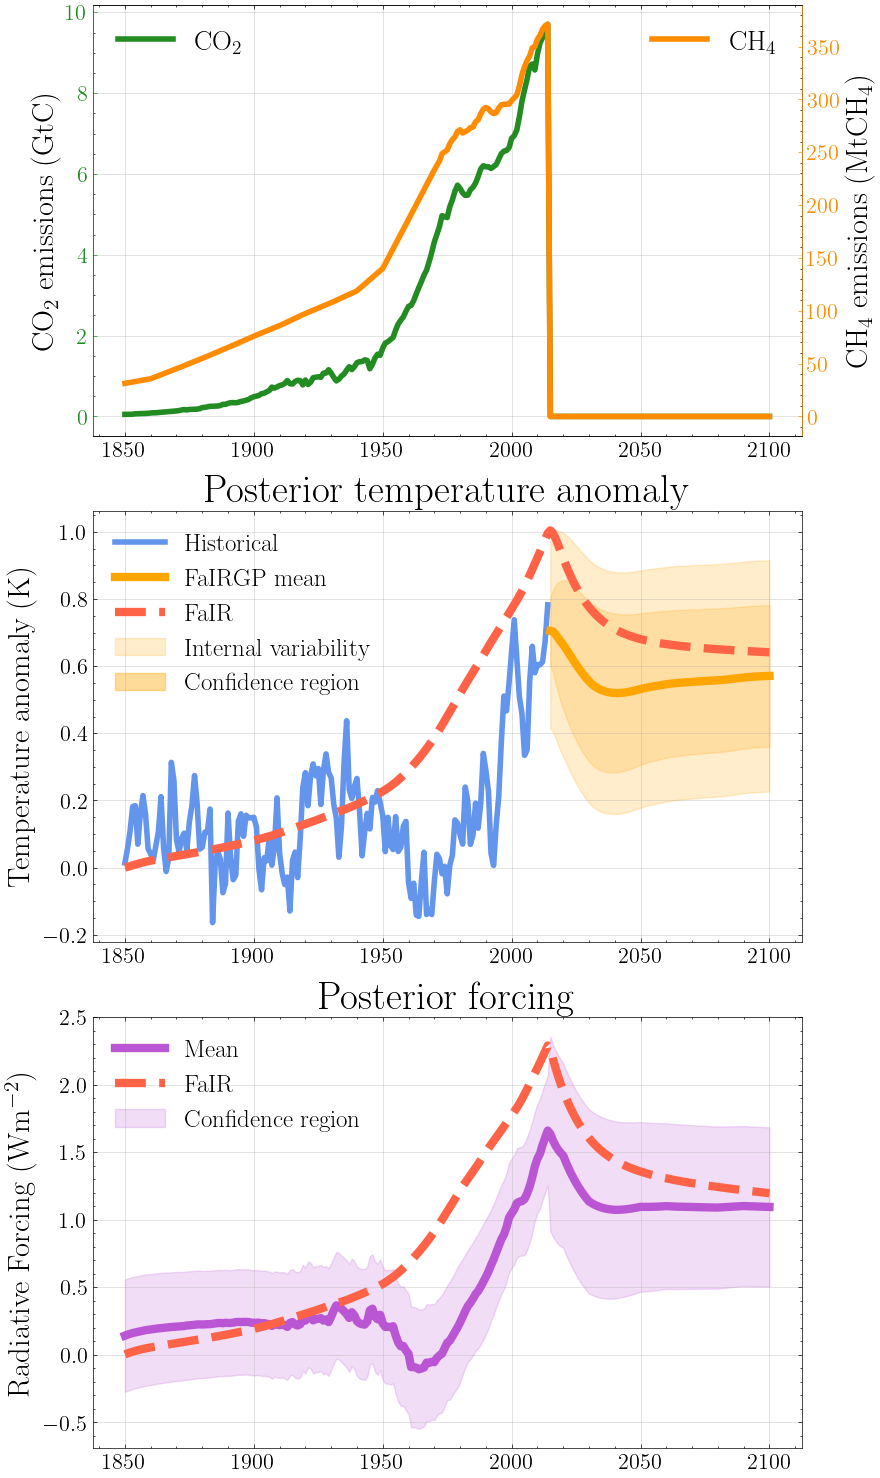

In [56]:
fig, ax = plt.subplots(3, 1, figsize=(9, 15))

ax[0].plot(test_times, stopGHG.full_emissions[:, 0], lw=4, color='forestgreen', label=r'CO$_2$')
ax[0].set_ylabel(r'CO$_2$ emissions (GtC)', fontsize=22)
ax[0].tick_params(labelsize=16)
ax[0].grid(alpha=0.5)
ax[0].legend(fontsize=20, loc='upper left')
ax[0].tick_params(axis='y', colors='forestgreen')
ax2 = ax[0].twinx()
ax2.plot(test_times, stopGHG.full_emissions[:, 1], lw=4, color='darkorange', label=r'CH$_4$')
ax2.set_ylabel(r'CH$_4$ emissions (MtCH$_4$)', fontsize=22)
ax2.tick_params(labelsize=16)
ax2.tick_params(axis='y', colors='darkorange')
ax2.spines['right'].set_color('darkorange')
ax2.spines['left'].set_color('forestgreen')
ax2.legend(fontsize=20, loc='upper right')



ax[1].plot(hist_renamed.timesteps, hist_renamed.tas, lw=4, color='cornflowerblue', label='Historical')
ax[1].plot(stopGHG.timesteps, fairgp_posterior_mean, color='orange', lw=6, label='FaIRGP mean')
ax[1].plot(stopGHG.full_timesteps, test_tas_fair, color='tomato', ls='--', lw=6, label='FaIR')
ax[1].fill_between(stopGHG.timesteps, fairgp_posterior_lb, fairgp_posterior_ub, alpha=0.2, color='orange',
                   label='Internal variability')
ax[1].fill_between(stopGHG.timesteps, noisy_fairgp_posterior_lb, noisy_fairgp_posterior_ub, alpha=0.2, color='orange',
                   label='Confidence region')
ax[1].tick_params(labelsize=16)
ax[1].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[1].grid(alpha=0.5)
ax[1].set_title(r'Posterior temperature anomaly', fontsize=28)

legend = ax[1].legend(loc='upper left', fontsize=18)
legend.legendHandles[4].set_alpha(0.4)


ax[2].plot(test_scenarios.full_timesteps, posterior_forcing_mean, color='mediumorchid', lw=6, label='Mean')
ax[2].plot(test_scenarios.full_timesteps, mF, color='tomato', ls='--', lw=6, label='FaIR')
ax[2].fill_between(test_scenarios.full_timesteps, posterior_forcing_lb, 
                      posterior_forcing_ub, alpha=0.2, color='mediumorchid',
                      label='Confidence region')
ax[2].tick_params(labelsize=16)
ax[2].set_ylabel(r'Radiative Forcing (Wm$^{-2}$)', fontsize=22)
ax[2].grid(alpha=0.5)
ax[2].set_title(r'Posterior forcing', fontsize=28)
ax[2].legend(loc='upper left', fontsize=18)



plt.tight_layout()
plt.savefig('stop-GHG-figure-2.png', dpi=300)
plt.show()

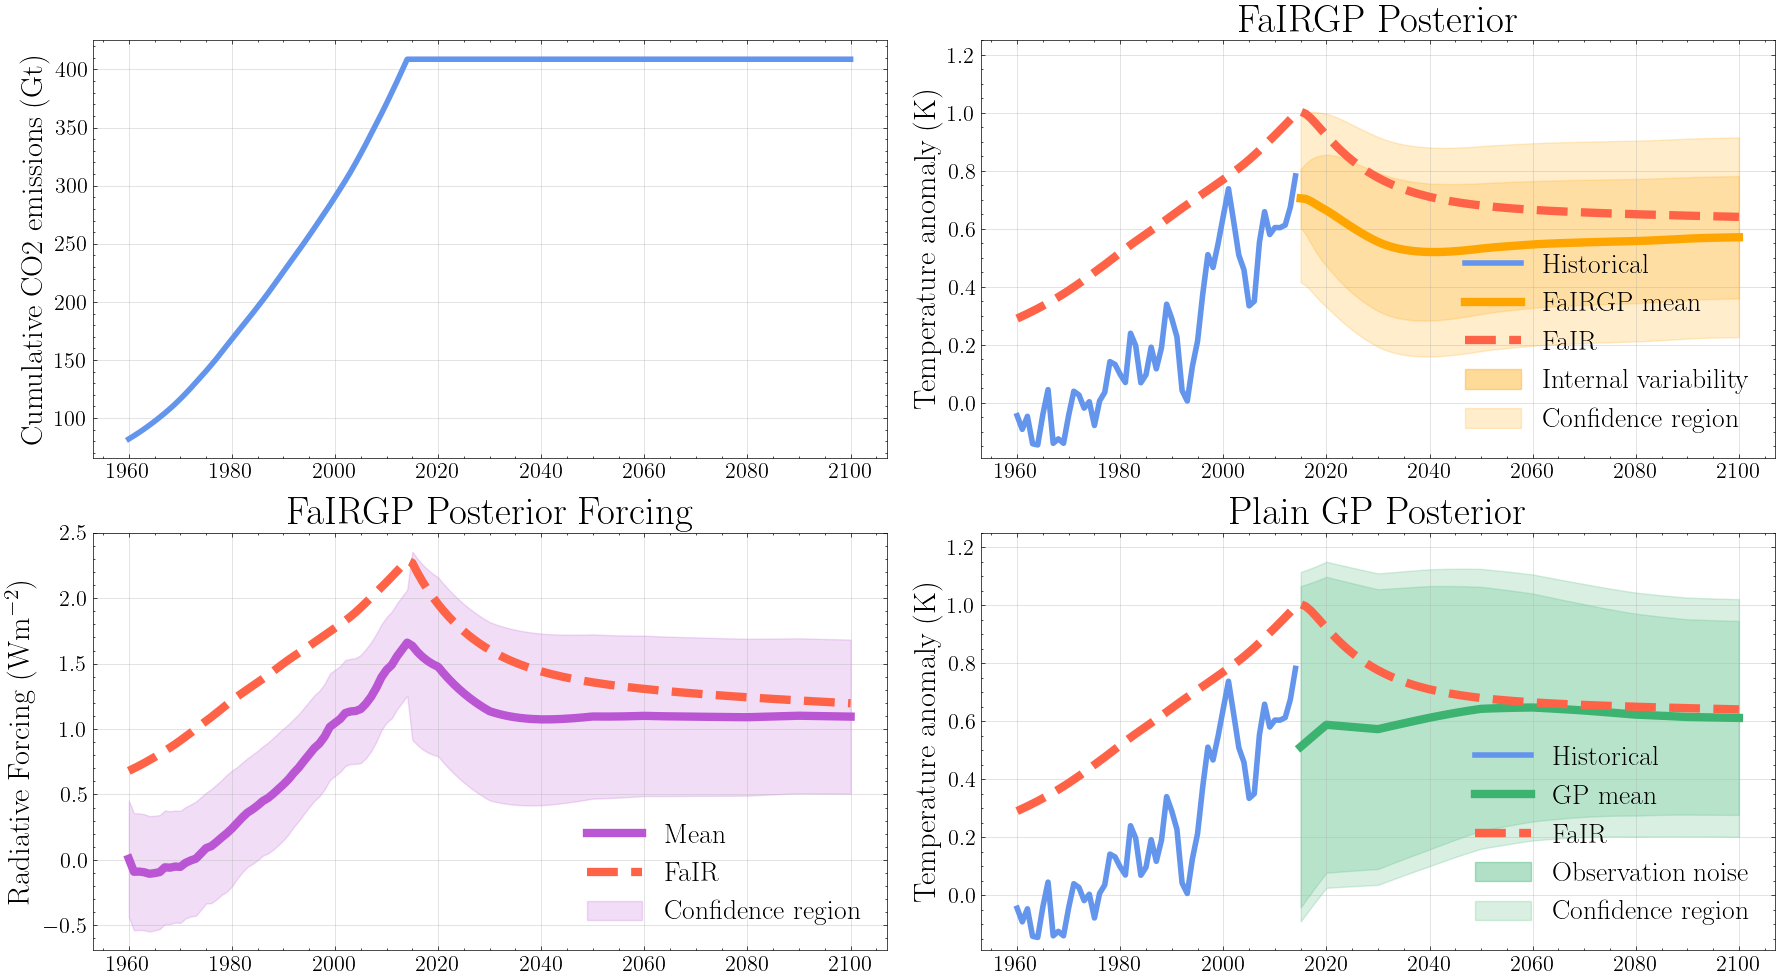

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(18, 10))

ymax = max(noisy_fairgp_posterior_ub.max(), noisy_gp_posterior_ub.max()) + 0.1
ymin = min(noisy_fairgp_posterior_lb.min(), noisy_gp_posterior_lb.min()) - 0.1
tshift = 110


ax[0, 0].plot(test_times[tshift:], stopGHG.full_cum_emissions[tshift:, 0], lw=4, color='cornflowerblue')
ax[0, 0].set_ylabel('Cumulative CO2 emissions (Gt)', fontsize=22)
ax[0, 0].tick_params(labelsize=16)
ax[0, 0].grid(alpha=0.5)


ax[1, 0].plot(test_times[tshift:], posterior_forcing_mean[tshift:], color='mediumorchid', lw=6, label='Mean')
ax[1, 0].plot(test_times[tshift:], mF[tshift:], color='tomato', ls='--', lw=6, label='FaIR')
ax[1, 0].fill_between(test_times[tshift:], posterior_forcing_lb[tshift:], 
                      posterior_forcing_ub[tshift:], alpha=0.2, color='mediumorchid',
                      label='Confidence region')
ax[1, 0].tick_params(labelsize=16)
ax[1, 0].set_ylabel(r'Radiative Forcing (Wm$^{-2}$)', fontsize=22)
ax[1, 0].grid(alpha=0.5)
ax[1, 0].set_title(r'FaIRGP Posterior Forcing', fontsize=28)
ax[1, 0].legend(loc='lower right', fontsize=20)

ax[0, 1].plot(hist_renamed.timesteps[tshift:], hist_renamed.tas[tshift:], lw=4, color='cornflowerblue', label='Historical')
ax[0, 1].plot(stopGHG.timesteps, fairgp_posterior_mean, color='orange', lw=6, label='FaIRGP mean')
ax[0, 1].plot(stopGHG.full_timesteps[tshift:], test_tas_fair[tshift:], color='tomato', ls='--', lw=6, label='FaIR')
ax[0, 1].fill_between(stopGHG.timesteps, fairgp_posterior_lb, fairgp_posterior_ub, alpha=0.2, color='orange',
                   label='Internal variability')
ax[0, 1].fill_between(stopGHG.timesteps, noisy_fairgp_posterior_lb, noisy_fairgp_posterior_ub, alpha=0.2, color='orange',
                   label='Confidence region')
ax[0, 1].tick_params(labelsize=16)
ax[0, 1].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[0, 1].grid(alpha=0.5)
ax[0, 1].set_ylim(ymin, ymax)
ax[0, 1].set_title(r'FaIRGP Posterior', fontsize=28)

legend = ax[0, 1].legend(loc='lower right', fontsize=20)
legend.legendHandles[3].set_alpha(0.4)


ax[1, 1].plot(hist_renamed.timesteps[tshift:], hist_renamed.tas[tshift:], lw=4, color='cornflowerblue', label='Historical')
ax[1, 1].plot(stopGHG.timesteps, gp_posterior_mean, color='mediumseagreen', lw=6, label='GP mean')
ax[1, 1].plot(stopGHG.full_timesteps[tshift:], test_tas_fair[tshift:], color='tomato', ls='--', lw=6, label='FaIR')
ax[1, 1].fill_between(stopGHG.timesteps, gp_posterior_lb, gp_posterior_ub, alpha=0.2, color='mediumseagreen',
                   label='Observation noise')
ax[1, 1].fill_between(stopGHG.timesteps, noisy_gp_posterior_lb, noisy_gp_posterior_ub, alpha=0.2, color='mediumseagreen',
               label='Confidence region')
ax[1, 1].tick_params(labelsize=16)
ax[1, 1].grid(alpha=0.5)
ax[1, 1].set_ylim(ymin, ymax)
ax[1, 1].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[1, 1].set_title(r'Plain GP Posterior', fontsize=28)

legend = ax[1, 1].legend(loc='lower right', fontsize=20)
legend.legendHandles[3].set_alpha(0.4)

plt.tight_layout()
# plt.savefig('stop-GHG-figure.png', dpi=300)
plt.show()

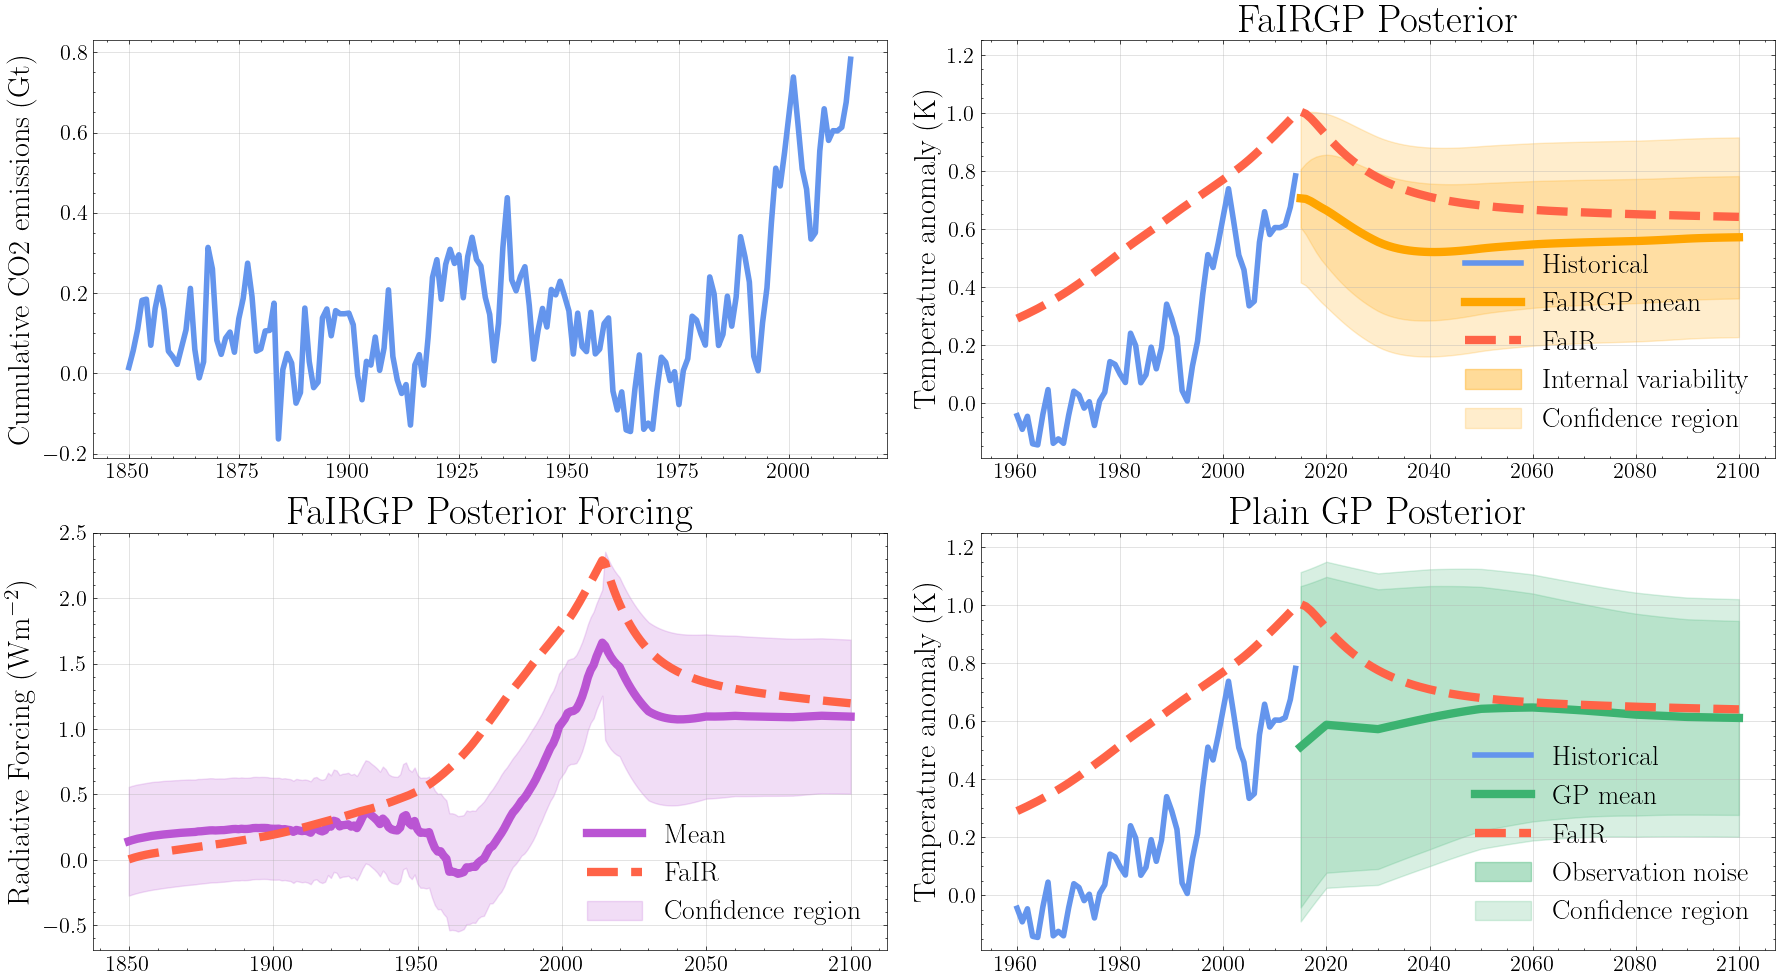

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(18, 10))

ymax = max(noisy_fairgp_posterior_ub.max(), noisy_gp_posterior_ub.max()) + 0.1
ymin = min(noisy_fairgp_posterior_lb.min(), noisy_gp_posterior_lb.min()) - 0.1
tshift = 110


ax[0, 0].plot(test_times, stopGHG.full_tas, lw=4, color='cornflowerblue')
ax[0, 0].set_ylabel('Cumulative CO2 emissions (Gt)', fontsize=22)
ax[0, 0].tick_params(labelsize=16)
ax[0, 0].grid(alpha=0.5)


ax[1, 0].plot(test_times, posterior_forcing_mean, color='mediumorchid', lw=6, label='Mean')
ax[1, 0].plot(test_times, mF, color='tomato', ls='--', lw=6, label='FaIR')
ax[1, 0].fill_between(test_times, posterior_forcing_lb, 
                      posterior_forcing_ub, alpha=0.2, color='mediumorchid',
                      label='Confidence region')
ax[1, 0].tick_params(labelsize=16)
ax[1, 0].set_ylabel(r'Radiative Forcing (Wm$^{-2}$)', fontsize=22)
ax[1, 0].grid(alpha=0.5)
ax[1, 0].set_title(r'FaIRGP Posterior Forcing', fontsize=28)
ax[1, 0].legend(loc='lower right', fontsize=20)

ax[0, 1].plot(hist_renamed.timesteps[tshift:], hist_renamed.tas[tshift:], lw=4, color='cornflowerblue', label='Historical')
ax[0, 1].plot(stopGHG.timesteps, fairgp_posterior_mean, color='orange', lw=6, label='FaIRGP mean')
ax[0, 1].plot(stopGHG.full_timesteps[tshift:], test_tas_fair[tshift:], color='tomato', ls='--', lw=6, label='FaIR')
ax[0, 1].fill_between(stopGHG.timesteps, fairgp_posterior_lb, fairgp_posterior_ub, alpha=0.2, color='orange',
                   label='Internal variability')
ax[0, 1].fill_between(stopGHG.timesteps, noisy_fairgp_posterior_lb, noisy_fairgp_posterior_ub, alpha=0.2, color='orange',
                   label='Confidence region')
ax[0, 1].tick_params(labelsize=16)
ax[0, 1].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[0, 1].grid(alpha=0.5)
ax[0, 1].set_ylim(ymin, ymax)
ax[0, 1].set_title(r'FaIRGP Posterior', fontsize=28)

legend = ax[0, 1].legend(loc='lower right', fontsize=20)
legend.legendHandles[3].set_alpha(0.4)


ax[1, 1].plot(hist_renamed.timesteps[tshift:], hist_renamed.tas[tshift:], lw=4, color='cornflowerblue', label='Historical')
ax[1, 1].plot(stopGHG.timesteps, gp_posterior_mean, color='mediumseagreen', lw=6, label='GP mean')
ax[1, 1].plot(stopGHG.full_timesteps[tshift:], test_tas_fair[tshift:], color='tomato', ls='--', lw=6, label='FaIR')
ax[1, 1].fill_between(stopGHG.timesteps, gp_posterior_lb, gp_posterior_ub, alpha=0.2, color='mediumseagreen',
                   label='Observation noise')
ax[1, 1].fill_between(stopGHG.timesteps, noisy_gp_posterior_lb, noisy_gp_posterior_ub, alpha=0.2, color='mediumseagreen',
               label='Confidence region')
ax[1, 1].tick_params(labelsize=16)
ax[1, 1].grid(alpha=0.5)
ax[1, 1].set_ylim(ymin, ymax)
ax[1, 1].set_ylabel('Temperature anomaly (K)', fontsize=22)
ax[1, 1].set_title(r'Plain GP Posterior', fontsize=28)

legend = ax[1, 1].legend(loc='lower right', fontsize=20)
legend.legendHandles[3].set_alpha(0.4)

plt.tight_layout()
# plt.savefig('stop-GHG-figure.png', dpi=300)
plt.show()